In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plot
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
batch_size = 32
X_dim = 784
z_dim = 10
h_dim = 128
lambda_grad = 10
lr = 0.0001
n_disc = 5

In [3]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def plot_images(samples):
    fig = plot.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plot.subplot(gs[i])
        plot.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plot.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

# D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
# D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# D_W2 = tf.Variable(xavier_init([h_dim, 1]))
# D_b2 = tf.Variable(tf.zeros(shape=[1]))

# theta_D = [D_W1, D_W2, D_b1, D_b2]


z = tf.placeholder(tf.float32, shape=[None, z_dim])

# G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
# G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
# G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

# theta_G = [G_W1, G_W2, G_b1, G_b2]

In [6]:
def get_sample_z(size):
    return np.random.uniform(-1., 1., size=size)

In [7]:
def generator(z):
    with tf.variable_scope('generator') as scope:
        G_h1 = tf.layers.dense(z, units=h_dim, kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        G_out = tf.nn.sigmoid(tf.layers.dense(G_h1, units=X_dim, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer()))
        return G_out

In [8]:
def discriminator(x, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        D_h1 = tf.layers.dense(x, units=h_dim, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
        D_out = tf.layers.dense(D_h1, units=1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        return D_out

In [9]:
generator_sample = generator(z)
discriminator_real = discriminator(X)
discriminator_fake = discriminator(generator_sample, True)

In [10]:
epsilon = tf.random_uniform([batch_size, 1], minval=0.0, maxval=1.0)
interpolated = epsilon * X + (1 - epsilon) * generator_sample
grads = tf.gradients(discriminator(interpolated, True), [interpolated])[0]
grad_norm = tf.sqrt(tf.reduce_sum((grads) ** 2, axis=1))
gp = lambda_grad * tf.reduce_mean((grad_norm - 1) ** 2)

In [11]:
d_loss = tf.reduce_mean(discriminator_fake) - tf.reduce_mean(discriminator_real) + gp
g_loss = -tf.reduce_mean(discriminator_fake)

In [13]:
g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
d_vars = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

d_step = (tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(d_loss, var_list=d_vars))
g_step = (tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(g_loss, var_list=g_vars))

In [14]:
print(g_vars)

[<tf.Variable 'generator/dense/kernel:0' shape=(10, 128) dtype=float32_ref>, <tf.Variable 'generator/dense/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'generator/dense_1/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'generator/dense_1/bias:0' shape=(784,) dtype=float32_ref>]


In [15]:
print(d_vars)

[<tf.Variable 'discriminator/dense/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'discriminator/dense/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/bias:0' shape=(1,) dtype=float32_ref>]


In [17]:
sess = tf.InteractiveSession()

In [18]:
sess.run(tf.global_variables_initializer())

Iteration: 0 - Discriminator Loss: -0.09984, Generator Loss: 0.2928


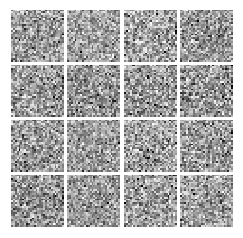

Iteration: 100 - Discriminator Loss: 14.47, Generator Loss: 19.34
Iteration: 200 - Discriminator Loss: 13.71, Generator Loss: 17.83
Iteration: 300 - Discriminator Loss: 13.03, Generator Loss: 15.6
Iteration: 400 - Discriminator Loss: 11.65, Generator Loss: 13.2
Iteration: 500 - Discriminator Loss: 10.32, Generator Loss: 10.64
Iteration: 600 - Discriminator Loss: 8.746, Generator Loss: 8.37
Iteration: 700 - Discriminator Loss: 7.857, Generator Loss: 6.411
Iteration: 800 - Discriminator Loss: 6.668, Generator Loss: 4.53
Iteration: 900 - Discriminator Loss: 5.671, Generator Loss: 2.759
Iteration: 1000 - Discriminator Loss: 5.556, Generator Loss: 1.528


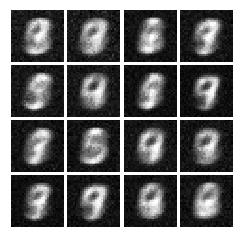

Iteration: 1100 - Discriminator Loss: 4.591, Generator Loss: 0.5924
Iteration: 1200 - Discriminator Loss: 4.826, Generator Loss: -0.02016
Iteration: 1300 - Discriminator Loss: 3.937, Generator Loss: -0.3012
Iteration: 1400 - Discriminator Loss: 4.171, Generator Loss: -0.6438
Iteration: 1500 - Discriminator Loss: 3.988, Generator Loss: -0.5931
Iteration: 1600 - Discriminator Loss: 4.112, Generator Loss: -0.6635
Iteration: 1700 - Discriminator Loss: 4.538, Generator Loss: -0.7255
Iteration: 1800 - Discriminator Loss: 3.574, Generator Loss: -0.7048
Iteration: 1900 - Discriminator Loss: 3.623, Generator Loss: -0.7712
Iteration: 2000 - Discriminator Loss: 3.269, Generator Loss: -0.5926


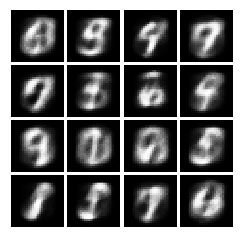

Iteration: 2100 - Discriminator Loss: 3.697, Generator Loss: -0.8502
Iteration: 2200 - Discriminator Loss: 3.299, Generator Loss: -0.748
Iteration: 2300 - Discriminator Loss: 3.326, Generator Loss: -0.7458
Iteration: 2400 - Discriminator Loss: 3.419, Generator Loss: -0.839
Iteration: 2500 - Discriminator Loss: 3.13, Generator Loss: -0.8349
Iteration: 2600 - Discriminator Loss: 3.011, Generator Loss: -0.76
Iteration: 2700 - Discriminator Loss: 3.097, Generator Loss: -0.8407
Iteration: 2800 - Discriminator Loss: 2.944, Generator Loss: -0.7511
Iteration: 2900 - Discriminator Loss: 2.904, Generator Loss: -0.84
Iteration: 3000 - Discriminator Loss: 3.057, Generator Loss: -0.7274


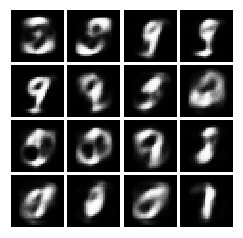

Iteration: 3100 - Discriminator Loss: 2.688, Generator Loss: -0.8539
Iteration: 3200 - Discriminator Loss: 2.836, Generator Loss: -0.9765
Iteration: 3300 - Discriminator Loss: 2.556, Generator Loss: -0.8151
Iteration: 3400 - Discriminator Loss: 2.793, Generator Loss: -0.7894
Iteration: 3500 - Discriminator Loss: 2.611, Generator Loss: -0.7985
Iteration: 3600 - Discriminator Loss: 2.675, Generator Loss: -0.9808
Iteration: 3700 - Discriminator Loss: 2.637, Generator Loss: -1.065
Iteration: 3800 - Discriminator Loss: 2.41, Generator Loss: -0.8642
Iteration: 3900 - Discriminator Loss: 2.365, Generator Loss: -0.8748
Iteration: 4000 - Discriminator Loss: 2.676, Generator Loss: -0.9702


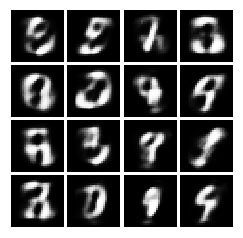

Iteration: 4100 - Discriminator Loss: 2.591, Generator Loss: -0.9955
Iteration: 4200 - Discriminator Loss: 2.331, Generator Loss: -0.9757
Iteration: 4300 - Discriminator Loss: 2.481, Generator Loss: -1.048
Iteration: 4400 - Discriminator Loss: 2.349, Generator Loss: -1.052
Iteration: 4500 - Discriminator Loss: 2.389, Generator Loss: -1.098
Iteration: 4600 - Discriminator Loss: 2.264, Generator Loss: -1.117
Iteration: 4700 - Discriminator Loss: 2.383, Generator Loss: -1.084
Iteration: 4800 - Discriminator Loss: 2.237, Generator Loss: -1.09
Iteration: 4900 - Discriminator Loss: 2.331, Generator Loss: -1.038
Iteration: 5000 - Discriminator Loss: 2.367, Generator Loss: -1.125


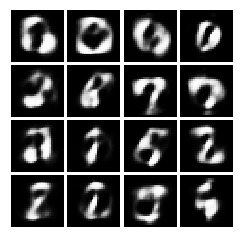

Iteration: 5100 - Discriminator Loss: 2.092, Generator Loss: -1.071
Iteration: 5200 - Discriminator Loss: 2.223, Generator Loss: -1.186
Iteration: 5300 - Discriminator Loss: 2.298, Generator Loss: -1.143
Iteration: 5400 - Discriminator Loss: 2.194, Generator Loss: -1.193
Iteration: 5500 - Discriminator Loss: 2.204, Generator Loss: -1.151
Iteration: 5600 - Discriminator Loss: 2.043, Generator Loss: -1.19
Iteration: 5700 - Discriminator Loss: 1.901, Generator Loss: -1.283
Iteration: 5800 - Discriminator Loss: 2.091, Generator Loss: -1.196
Iteration: 5900 - Discriminator Loss: 2.147, Generator Loss: -1.211
Iteration: 6000 - Discriminator Loss: 2.023, Generator Loss: -1.206


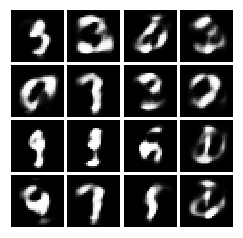

Iteration: 6100 - Discriminator Loss: 2.174, Generator Loss: -1.198
Iteration: 6200 - Discriminator Loss: 2.174, Generator Loss: -1.232
Iteration: 6300 - Discriminator Loss: 1.894, Generator Loss: -1.306
Iteration: 6400 - Discriminator Loss: 2.145, Generator Loss: -1.313
Iteration: 6500 - Discriminator Loss: 1.996, Generator Loss: -1.295
Iteration: 6600 - Discriminator Loss: 1.977, Generator Loss: -1.306
Iteration: 6700 - Discriminator Loss: 2.015, Generator Loss: -1.337
Iteration: 6800 - Discriminator Loss: 1.936, Generator Loss: -1.32
Iteration: 6900 - Discriminator Loss: 1.848, Generator Loss: -1.21
Iteration: 7000 - Discriminator Loss: 2.032, Generator Loss: -1.3


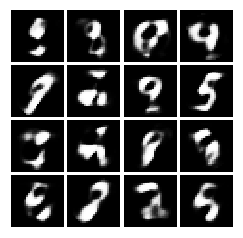

Iteration: 7100 - Discriminator Loss: 2.218, Generator Loss: -1.283
Iteration: 7200 - Discriminator Loss: 2.114, Generator Loss: -1.354
Iteration: 7300 - Discriminator Loss: 1.771, Generator Loss: -1.329
Iteration: 7400 - Discriminator Loss: 1.743, Generator Loss: -1.357
Iteration: 7500 - Discriminator Loss: 1.931, Generator Loss: -1.238
Iteration: 7600 - Discriminator Loss: 2.026, Generator Loss: -1.343
Iteration: 7700 - Discriminator Loss: 1.924, Generator Loss: -1.403
Iteration: 7800 - Discriminator Loss: 2.043, Generator Loss: -1.474
Iteration: 7900 - Discriminator Loss: 1.876, Generator Loss: -1.392
Iteration: 8000 - Discriminator Loss: 1.865, Generator Loss: -1.591


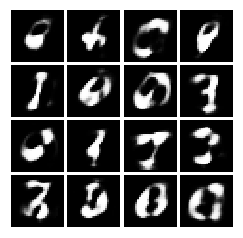

Iteration: 8100 - Discriminator Loss: 1.887, Generator Loss: -1.566
Iteration: 8200 - Discriminator Loss: 1.981, Generator Loss: -1.432
Iteration: 8300 - Discriminator Loss: 1.971, Generator Loss: -1.648


In [ ]:
for i in range(100000):
    for _ in range(n_disc):
        x_batch, _ = mnist.train.next_batch(batch_size)

        _, d_loss_val = sess.run(
            [d_step, d_loss],
            feed_dict={X: x_batch, z: get_sample_z(size=(batch_size, z_dim))}
        )

    _, g_loss_val = sess.run(
        [g_step, g_loss],
        feed_dict={z: get_sample_z(size=(batch_size, z_dim))}
    )

    if i % 100 == 0:
        print('Iteration: {} - Discriminator Loss: {:.4}, Generator Loss: {:.4}'
              .format(i, -d_loss_val, g_loss_val))

        if i % 1000 == 0:
            samples = sess.run(generator_sample, feed_dict={z: get_sample_z(size=(16, z_dim))})

            fig = plot_images(samples)
            plot.show()
            i += 1
            plot.close(fig)